In [1]:
# imports
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.preprocessing import PolynomialFeatures
# local
import wrangle as w
import explore as e
import modeling as m

In [2]:
# 52,441 rows to 51,046, drop less than 3%

In [3]:
df = w.wrangle_zillow()

In [4]:
df = w.encode_county(df)

## Full Explore Time

In [5]:
# df.describe().T

In [6]:
train,val,test = w.split_data(df)
train

,age,baths,beds,roomcnt,area,county,latitude,longitude,prop_value,Orange,LA,Ventura
9568,73,2.0,3,0.0,1001,LA,33800512.0,-118213302.0,265150,0,1,0
18363,3,2.0,3,6.0,1580,Orange,33634652.0,-117898149.0,1275356,1,0,0
2877,54,2.0,3,5.0,1128,Orange,33753941.0,-118032920.0,498221,1,0,0
30380,63,2.0,4,0.0,1188,LA,34213276.0,-118521205.0,105337,0,1,0
2657,75,2.0,3,0.0,1470,LA,33843316.0,-118173744.0,399808,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18920,44,2.5,3,5.0,1410,Orange,33890714.0,-117791168.0,452000,1,0,0
26843,49,2.0,3,6.0,1360,Orange,33617605.0,-117671395.0,583768,1,0,0
26089,27,2.5,4,0.0,1725,Orange,33582894.0,-117712323.0,294332,1,0,0
9979,29,2.0,3,0.0,1432,LA,34624529.0,-117848607.0,53049,0,1,0


In [7]:
# train.describe().T

In [8]:
# cols = train.drop(columns=['county']).columns.to_list()
# for col in cols:
#     train.corr()[col].sort_values(ascending = False).plot(kind='bar')
#     plt.title(col)
#     plt.show()

Spearman's R: area and prop_value
 r = 0.5017813399669965, p = 0.0


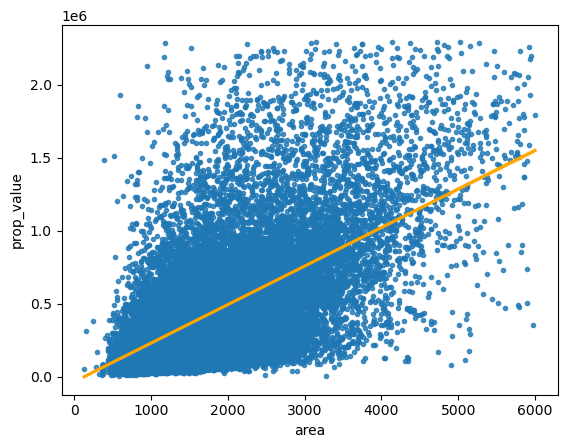

In [9]:
# explore area and property value
e.pear(train,'area','prop_value')
sns.regplot(data=train,x='area',y='prop_value',marker='.',line_kws={'color':'orange'})
plt.show()

Spearman's R: age and prop_value
 r = -0.26796888401105634, p = 0.0


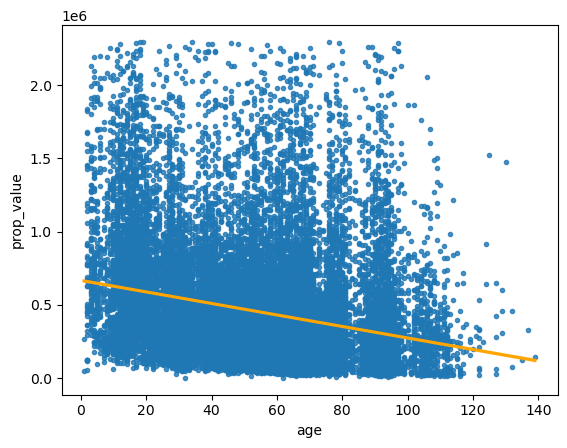

In [10]:
# explore age and property value
e.pear(train,'age','prop_value')
sns.regplot(data=train,x='age',y='prop_value',marker='.',line_kws={'color':'orange'})
plt.show()

Spearman's R: roomcnt and prop_value
 r = 0.07635447873979384, p = 7.760619779932516e-41


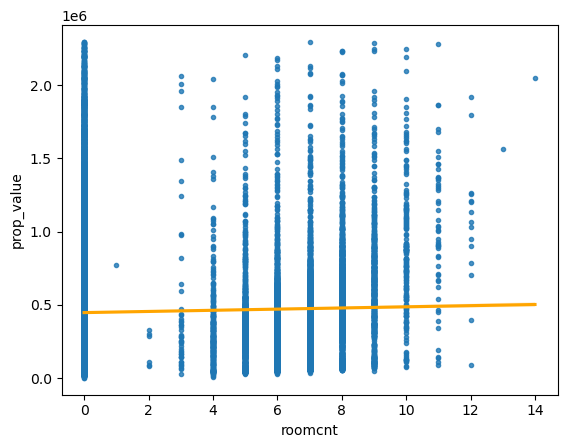

In [11]:
# explore room count and property value
e.pear(train,'roomcnt','prop_value')
sns.regplot(data=train,x='roomcnt',y='prop_value',marker='.',line_kws={'color':'orange'})
plt.show()

Kruskal-Wallis H-Test:
 stat = 1122.2740145413604, p = 2.0012168486441073e-244


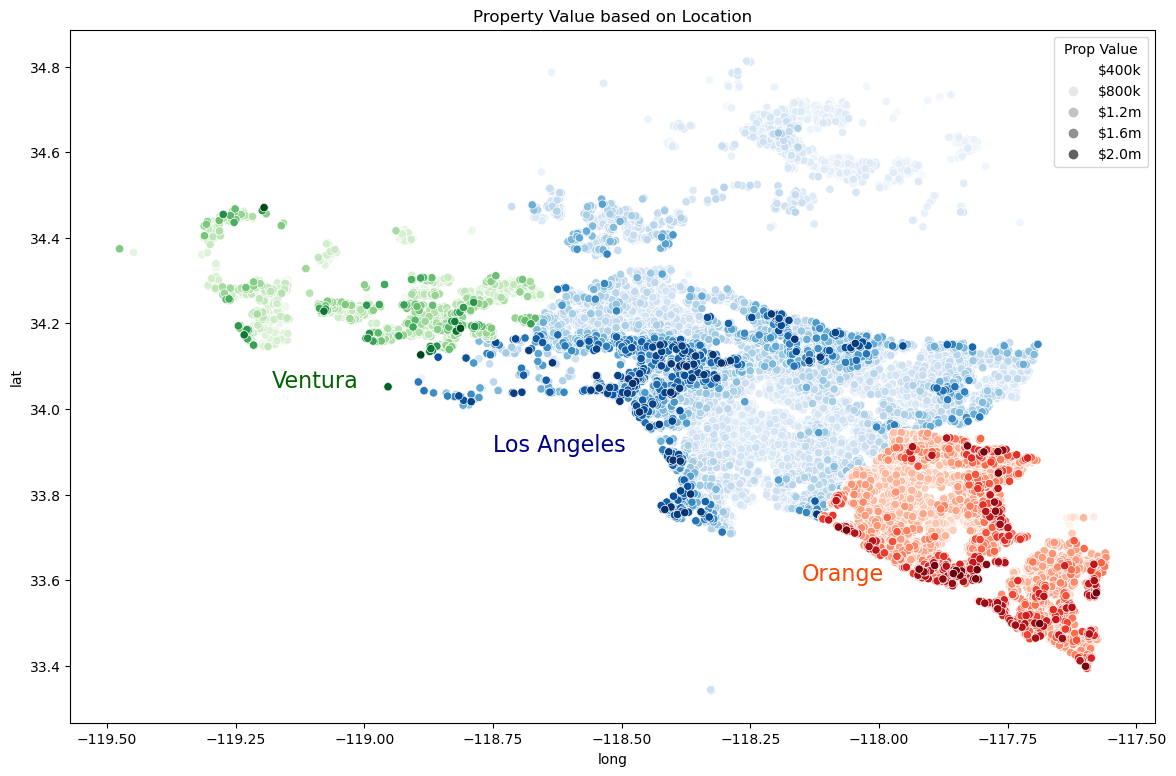

In [12]:
# explore average property value and counties
e.nova(train[train.county=='LA'].prop_value,train[train.county=='Orange'].prop_value,train[train.county=='Ventura'].prop_value)
e.plt_loc(train)

In [13]:
X_train,X_val,X_test = train.drop(columns=['prop_value','county']),val.drop(columns=['prop_value','county']),test.drop(columns=['prop_value','county'])
y_train,y_val,y_test = train[['prop_value']],val[['prop_value']],test[['prop_value']]

Xs_train,Xs_val,Xs_test = w.std_zillow(X_train,X_val,X_test)

In [14]:
Xs_train

,age_s,baths_s,beds_s,roomcnt_s,area_s,latitude_s,longitude_s,Orange_s,LA_s,Ventura_s
9568,0.827302,-0.262127,-0.304653,-0.606126,-1.019570,-0.813269,-0.062087,-0.607192,0.737043,-0.300140
18363,-2.224885,-0.262127,-0.304653,1.307637,-0.324492,-1.416487,0.828065,1.646926,-1.356772,-0.300140
2877,-0.001149,-0.262127,-0.304653,0.988676,-0.867109,-0.982643,0.447404,1.646926,-1.356772,-0.300140
30380,0.391275,-0.262127,0.791388,-0.606126,-0.795080,0.687918,-0.931761,-0.607192,0.737043,-0.300140
2657,0.914507,-0.262127,-0.304653,-0.606126,-0.456545,-0.657594,0.049645,-0.607192,0.737043,-0.300140
...,...,...,...,...,...,...,...,...,...,...
18920,-0.437176,0.281934,-0.304653,0.988676,-0.528574,-0.485212,1.130234,1.646926,-1.356772,-0.300140
26843,-0.219162,-0.262127,-0.304653,1.307637,-0.588598,-1.478485,1.468534,1.646926,-1.356772,-0.300140
26089,-1.178421,0.281934,0.791388,-0.606126,-0.150422,-1.604726,1.352932,1.646926,-1.356772,-0.300140
9979,-1.091216,-0.262127,-0.304653,-0.606126,-0.502163,2.183610,0.967997,-0.607192,0.737043,-0.300140


In [15]:
Xs_val

,age_s,baths_s,beds_s,roomcnt_s,area_s,latitude_s,longitude_s,Orange_s,LA_s,Ventura_s
15236,-1.658050,1.914118,1.887430,-0.606126,1.815966,-0.426225,1.014404,1.646926,-1.356772,-0.300140
18563,0.783699,0.825996,0.791388,-0.606126,0.936013,0.037998,-0.657468,-0.607192,0.737043,-0.300140
6096,-0.001149,-0.262127,0.791388,1.307637,-0.774672,0.901536,-1.685526,-0.607192,-1.356772,3.331779
35099,0.522083,-0.262127,-0.304653,-0.606126,-0.675032,-0.127743,-0.599715,-0.607192,0.737043,-0.300140
34487,-2.224885,0.281934,-0.304653,-0.606126,-0.174432,-1.291130,1.448251,1.646926,-1.356772,-0.300140
...,...,...,...,...,...,...,...,...,...,...
44988,-1.134818,0.281934,-0.304653,-0.606126,-0.548982,-1.568492,1.255264,1.646926,-1.356772,-0.300140
18167,-0.655189,0.825996,0.791388,1.626597,1.039254,-1.527827,1.453106,1.646926,-1.356772,-0.300140
33774,0.173262,-0.262127,-0.304653,1.307637,-0.202043,-1.240337,0.736094,1.646926,-1.356772,-0.300140
32340,0.652891,-1.350250,-1.400694,-0.606126,-1.284877,0.736733,-0.717093,-0.607192,0.737043,-0.300140


In [16]:
# df1 = None
# feat = Xs_train.drop(columns=['year_s','pools_s','Orange_s','hashottuborspa_s','garagecarcnt_s','fireplacecnt_s','stories_s']).columns
# # feat = Xs_train.columns
# for r in range(1,13):
#     dfr = rfe_rev(Xs_train[feat],y_train,r,True)
#     dfr = dfr.assign(n_features=r)
#     df1 = pd.concat([df1,dfr]) if df1 is not None else dfr
# df1.groupby(['Var']).Rank.mean().sort_values()

In [17]:
# train.garage.value_counts()

In [18]:
# def plt_loc(train):
#     '''toss in train data and get a pretty plot on lat long and prop value per county'''
#     # make xy label scale smaller
#     train[['latitude','longitude']] = train[['latitude','longitude']]/1000000
#     train = train.sort_values('prop_value')
#     # make the size
#     plt.figure(figsize=[14,9])
#     # generic legend example
#     sns.scatterplot(data=train,y='latitude',x='longitude',hue='prop_value',palette='Greys',alpha=1)
#     # plot per county the lat long, hue on prop value
#     sns.scatterplot(data=train[train.county=='LA'],y='latitude',x='longitude',hue='prop_value',palette='Blues')
#     sns.scatterplot(data=train[train.county=='Orange'],y='latitude',x='longitude',hue='prop_value',palette='Reds')
#     sns.scatterplot(data=train[train.county=='Ventura'],y='latitude',x='longitude',hue='prop_value',palette='Greens')
#     # label generic legend
#     plt.legend(title='Prop Value',labels=['$400k','$800k','$1.2m','$1.6m','$2.0m'])
#     # give it a name
#     plt.title('Property Value based on Location')
#     plt.show()
# plt_loc(train)

In [19]:
# cols = train.columns.to_list()
# spears = []
# for col in itertools.permutations(cols,2):
#     r,p = stats.spearmanr(train[col[0]], train[col[1]])
#     output = {
#             'column1':col[0],
#             'column2':col[1],
#             'r':round(r,6),
#             'p':round(p,6)
#         }
#     spears.append(output)
# df2 = pd.DataFrame(spears)


In [20]:
# df2

In [21]:
# Does area correlate with prop_value?
# H0 = No correlation
# Ha = Yes correlation
# sns.regplot(data=train,x='area',y='prop_value',marker='.',line_kws={'color':'orange'})
# plt.show()

In [22]:
# pear(train,'area','prop_value')

In [23]:
# less than alpha = .05
# yes correlation

In [24]:
# train.prop_value.mean()

In [25]:
y_train.mean()[0]

454401.6769190584

In [26]:
def metrics_reg(y, yhat):
    """
    send in y_true, y_pred & returns RMSE, R2
    """
    rmse = mean_squared_error(y, yhat, squared=False)
    r2 = r2_score(y, yhat)
    return round(rmse,2), round(r2,4)

In [27]:
def reg_mods(Xtr,ytr,Xv,yv,features=None,alpha=1,degree=2):
    '''
    Input X_train,y_train,X_val,y_val, list of features, alpha, and degree
    so that function will run through linear regression, lasso lars, and
    polynomial feature regression
    - diff feature combos
    - diff hyper params
    - output as df
    '''
    if features is None:
        features = Xtr.columns.to_list()
    # baseline as mean
    pred_mean = ytr.mean()[0]
    ytr_p = ytr.assign(pred_mean=pred_mean)
    yv_p = yv.assign(pred_mean=pred_mean)
    rmse_tr = mean_squared_error(ytr,ytr_p.pred_mean)**.5
    rmse_v = mean_squared_error(yv,yv_p.pred_mean)**.5
    r2_tr = r2_score(ytr, ytr_p.pred_mean)
    r2_v = r2_score(yv, yv_p.pred_mean)
    output = {
            'model':'bl_mean',
            'features':'None',
            'params':'None',
            'rmse_tr':rmse_tr,
            'rmse_v':rmse_v,
            'r2_tr':r2_tr,
            'r2_v':r2_v
        }
    metrics = [output]
    # create iterable for feature combos
    for r in range(1,(len(features)+1)):
        # cycle through feature combos for linear reg
        for feature in itertools.combinations(features,r):
            f = list(feature)
            # linear regression
            lr = LinearRegression()
            lr.fit(Xtr[f],ytr)
            # metrics
            pred_lr_tr = lr.predict(Xtr[f])
            rmse_tr,r2_tr = metrics_reg(ytr,pred_lr_tr)
            pred_lr_v = lr.predict(Xv[f])
            rmse_v,r2_v = metrics_reg(yv,pred_lr_v)
            # table-ize
            output ={
                    'model':'LinearRegression',
                    'features':f,
                    'params':'None',
                    'rmse_tr':rmse_tr,
                    'rmse_v':rmse_v,
                    'r2_tr':r2_tr,
                    'r2_v':r2_v
                }
            metrics.append(output)
        # cycle through feature combos and alphas for lasso lars
        for feature,a in itertools.product(itertools.combinations(features,r),alpha):
            f = list(feature)
            # lasso lars
            ll = LassoLars(alpha=a,normalize=False,random_state=42)
            ll.fit(Xtr[f],ytr)
            # metrics
            pred_ll_tr = ll.predict(Xtr[f])
            rmse_tr,r2_tr = metrics_reg(ytr,pred_ll_tr)
            pred_ll_v = ll.predict(Xv[f])
            rmse_v,r2_v = metrics_reg(yv,pred_ll_v)
            # table-ize
            output ={
                    'model':'LassoLars',
                    'features':f,
                    'params':f'alpha={a}',
                    'rmse_tr':rmse_tr,
                    'rmse_v':rmse_v,
                    'r2_tr':r2_tr,
                    'r2_v':r2_v
                }
            metrics.append(output)
        # cycle through feature combos and degrees for polynomial feature reg
        for feature,d in itertools.product(itertools.combinations(features,r),degree):
            f = list(feature)
            # polynomial feature regression
            pf = PolynomialFeatures(degree=d)
            Xtr_pf = pf.fit_transform(Xtr[f])
            Xv_pf = pf.transform(Xv[f])
            lp = LinearRegression()
            lp.fit(Xtr_pf,ytr)
            # metrics
            pred_lp_tr = lp.predict(Xtr_pf)
            rmse_tr,r2_tr = metrics_reg(ytr,pred_lp_tr)
            pred_lp_v = lp.predict(Xv_pf)
            rmse_v,r2_v = metrics_reg(yv,pred_lp_v)
            # table-ize
            output ={
                    'model':'PolynomialFeature',
                    'features':f,
                    'params':f'degree={d}',
                    'rmse_tr':rmse_tr,
                    'rmse_v':rmse_v,
                    'r2_tr':r2_tr,
                    'r2_v':r2_v
                }
            metrics.append(output)
    return pd.DataFrame(metrics)

In [28]:
# feat = ['baths_s','beds_s', 'roomcnt_s', 'area_s', 'latitude_s', 'longitude_s', 'LA_s', 'Ventura_s', 'age_s']
# metrics = reg_mods(Xs_train,y_train,Xs_val,y_val,alpha=[1,2],degree=[2,3,4],features=feat)
# metrics

In [29]:
# poly best f=['beds_s', 'area_s', 'latitude_s', 'longitude_s', 'LA_s', 'Ventura_s', 'age_s'], degree=4
# lin reg f=['baths_s', 'beds_s', 'roomcnt_s', 'area_s', 'latitude_s', 'longitude_s', 'LA_s', 'Ventura_s', 'age_s']
# lasso f=['baths_s', 'beds_s', 'roomcnt_s', 'area_s', 'latitude_s', 'longitude_s', 'LA_s', 'Ventura_s', 'age_s'], alpha=1
# ['baths_s','beds_s', 'area_s', 'roomcnt_s', 'latitude_s', 'longitude_s', 'LA_s', 'Ventura_s', 'age_s']

In [30]:
def final_model(model,X_train,y_train,X_val,y_val):
    if model == 'lr':
        # features
        f=['baths_s', 'beds_s', 'roomcnt_s', 'area_s', 'latitude_s', 'longitude_s', 'LA_s', 'Ventura_s', 'age_s']
        # model
        lr = LinearRegression()
        lr.fit(X_train[f],y_train)
        # metrics
        pred_lr_tr = lr.predict(X_train[f])
        rmse_tr,r2_tr = metrics_reg(y_train,pred_lr_tr)
        pred_lr_v = lr.predict(X_val[f])
        rmse_v,r2_v = metrics_reg(y_val,pred_lr_v)
        print('Linear Regression')
        print(f'Train       RMSE: {rmse_tr}   R2: {r2_tr}')
        print(f'Validate    RMSE: {rmse_v}    R2: {r2_v}')
    elif model == 'poly':
        # features
        f=['beds_s', 'area_s', 'latitude_s', 'longitude_s', 'LA_s', 'Ventura_s', 'age_s']
        # polynomial feature regression
        pf = PolynomialFeatures(degree=4)
        X_train_pf = pf.fit_transform(X_train[f])
        X_val_pf = pf.transform(X_val[f])
        # model
        pr = LinearRegression()
        pr.fit(X_train_pf,y_train)
        # metrics
        pred_pr_tr = pr.predict(X_train_pf)
        rmse_tr,r2_tr = metrics_reg(y_train,pred_pr_tr)
        pred_pr_v = pr.predict(X_val_pf)
        rmse_v,r2_v = metrics_reg(y_val,pred_pr_v)
        print('Polynomial Features through Linear Regression')
        print(f'Train       RMSE: {rmse_tr}   R2: {r2_tr}')
        print(f'Validate    RMSE: {rmse_v}    R2: {r2_v}')
    elif model == 'lasso':
        # features
        f=['baths_s', 'beds_s', 'roomcnt_s', 'area_s', 'latitude_s', 'longitude_s', 'LA_s', 'Ventura_s', 'age_s']
        # model
        ll = LassoLars(alpha=1,normalize=False)
        ll.fit(X_train[f],y_train)
        # metrics
        pred_ll_tr = ll.predict(X_train[f])
        rmse_tr,r2_tr = metrics_reg(y_train,pred_ll_tr)
        pred_ll_v = ll.predict(X_val[f])
        rmse_v,r2_v = metrics_reg(y_val,pred_ll_v)
        print('Lasso Lars')
        print(f'Train       RMSE: {rmse_tr}   R2: {r2_tr}')
        print(f'Validate    RMSE: {rmse_v}    R2: {r2_v}')
    else:
        print('Please include model argument: lr, poly, lasso')

In [31]:
final_model('lr',Xs_train,y_train,Xs_val,y_val)

Linear Regression
Train       RMSE: 287574.6   R2: 0.4158
Validate    RMSE: 290807.5    R2: 0.397


In [32]:
final_model('poly',Xs_train,y_train,Xs_val,y_val)

Polynomial Features through Linear Regression
Train       RMSE: 266137.07   R2: 0.4996
Validate    RMSE: 274174.47    R2: 0.464


In [33]:
final_model('lasso',Xs_train,y_train,Xs_val,y_val)

Lasso Lars
Train       RMSE: 287574.6   R2: 0.4158
Validate    RMSE: 290807.44    R2: 0.397


In [34]:
def test_model(X_train,y_train,X_test,y_test):
    # features
    f=['beds_s', 'area_s', 'latitude_s', 'longitude_s', 'LA_s', 'Ventura_s', 'age_s']
    # polynomial feature regression
    pf = PolynomialFeatures(degree=4)
    X_train_pf = pf.fit_transform(X_train[f])
    X_test_pf = pf.transform(X_test[f])
    # model
    pr = LinearRegression()
    pr.fit(X_train_pf,y_train)
    # metrics
    pred_pr_t = pr.predict(X_test_pf)
    rmse_t,r2_t = metrics_reg(y_test,pred_pr_t)
    print('Polynomial Features through Linear Regression')
    print(f'Test    RMSE: {rmse_t}    R2: {r2_t}')

In [35]:
test_model(Xs_train,y_train,Xs_test,y_test)

Polynomial Features through Linear Regression
Test    RMSE: 270756.91    R2: 0.4851


In [36]:
def plt_err(Xs_train,y_train,Xs_test,y_test):
    # features
    f=['beds_s', 'area_s', 'latitude_s', 'longitude_s', 'LA_s', 'Ventura_s', 'age_s']
    # polynomial feature regression
    pf = PolynomialFeatures(degree=4)
    X_train_pf = pf.fit_transform(Xs_train[f])
    X_test_pf = pf.transform(Xs_test[f])
    # model
    pr = LinearRegression()
    pr.fit(X_train_pf,y_train)
    # metrics
    pred_pr_t = pd.DataFrame(pr.predict(X_test_pf),index=y_test.index,columns=['y_pred'])
    pred_mean = y_test
    pred_mean = pred_mean.assign(baseline=pred_mean.prop_value.mean())
    plt.figure(figsize=(16,8))
    plt.plot(y_test, pred_mean.baseline, alpha=.5, color="black", label='_nolegend_')
    plt.annotate("Baseline: Predict Using Mean", (1800000, 350000))
    plt.plot(y_test, y_test, alpha=.5, color="blue", label='_nolegend_')
    plt.annotate("The Ideal Line: Predicted = Actual", (1800000, 1850000), rotation=24.5)
    plt.scatter(y_test, pred_pr_t, alpha=.2, color="green", s=100, label="Model 4th degree Polynomial")
    plt.legend()
    plt.xlabel("Actual Property Value ($ Millions)")
    plt.ylabel("Predicted Property Value ($ Millions)")
    plt.title("Where are predictions more extreme? More modest?")
    plt.show()

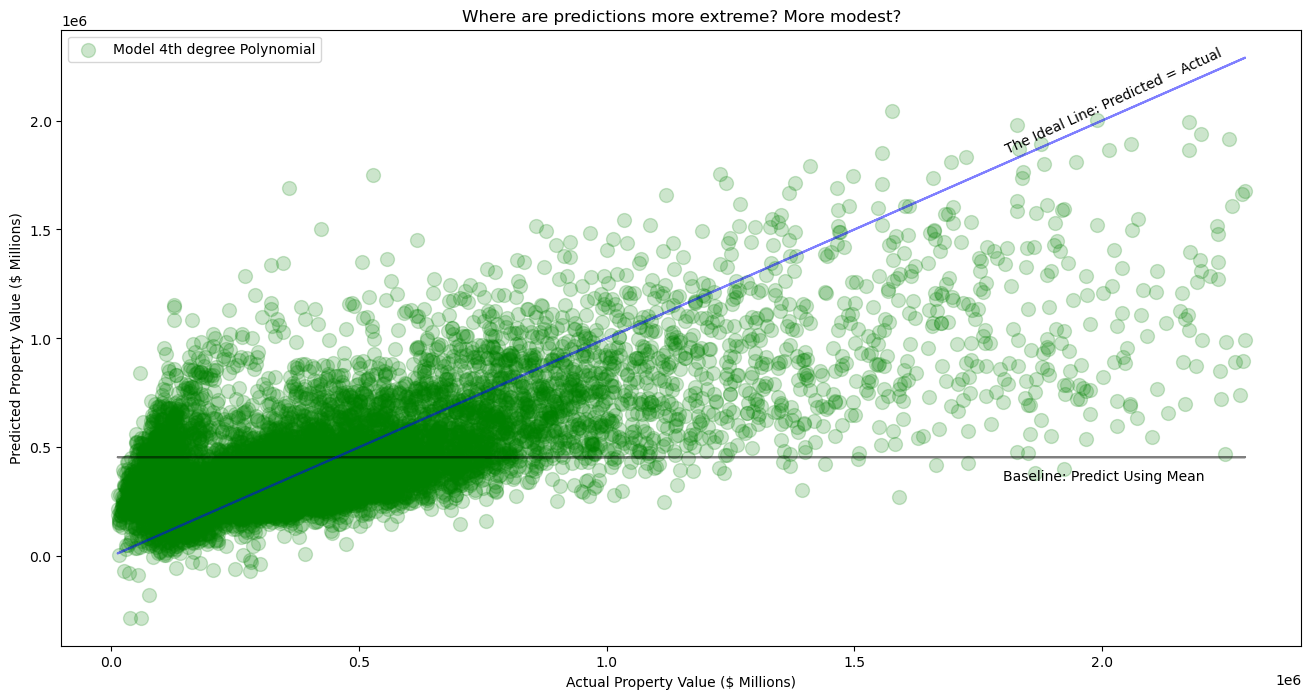

In [37]:
plt_err(Xs_train,y_train,Xs_test,y_test)